# Movie Information ChatBot

## Set-up environment

In [1]:
import os
import pandas as pd

In [2]:
import langdetect
from langdetect import DetectorFactory, detect, detect_langs

In [3]:
from langchain.llms import Ollama
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain.prompts import PromptTemplate

In [4]:
# Embedding facilities
from langchain.embeddings import HuggingFaceEmbeddings
# Pipelines
from langchain import HuggingFacePipeline
from langchain.chains import RetrievalQA

## Data Collection

In [5]:
df = pd.read_csv('Data/title.basics.tsv', sep='\t')

/var/folders/j8/90cw3p5n71g7h09g80k64v680000gn/T/ipykernel_61970/3803222917.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Data/title.basics.tsv', sep='\t')


In [6]:
df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,5,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10790736 entries, 0 to 10790735
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   tconst          object
 1   titleType       object
 2   primaryTitle    object
 3   originalTitle   object
 4   isAdult         object
 5   startYear       object
 6   endYear         object
 7   runtimeMinutes  object
 8   genres          object
dtypes: object(9)
memory usage: 740.9+ MB


In [8]:
df['titleType'].unique()

array(['short', 'movie', 'tvShort', 'tvMovie', 'tvSeries', 'tvEpisode',
       'tvMiniSeries', 'tvSpecial', 'video', 'videoGame', 'tvPilot'],
      dtype=object)

In [9]:
movie_df = df[df['titleType'].isin(['short', 'movie', 'tvMovie'])]
movie_df

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,5,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"
...,...,...,...,...,...,...,...,...,...
10790676,tt9916730,movie,6 Gunn,6 Gunn,0,2017,\N,116,Drama
10790686,tt9916754,movie,Chico Albuquerque - Revelações,Chico Albuquerque - Revelações,0,2013,\N,49,Documentary
10790687,tt9916756,short,Pretty Pretty Black Girl,Pretty Pretty Black Girl,0,2019,\N,\N,Short
10790691,tt9916764,short,38,38,0,2018,\N,\N,Short


In [10]:
title_df = movie_df[['originalTitle']]
title_df

,originalTitle
0,Carmencita
1,Le clown et ses chiens
2,Pauvre Pierrot
3,Un bon bock
4,Blacksmith Scene
...,...
10790676,6 Gunn
10790686,Chico Albuquerque - Revelações
10790687,Pretty Pretty Black Girl
10790691,38


In [11]:
title_df.isnull().sum()

originalTitle    5
dtype: int64

In [12]:
title_df = title_df.dropna()

In [13]:
title_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1823035 entries, 0 to 10790734
Data columns (total 1 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   originalTitle  object
dtypes: object(1)
memory usage: 27.8+ MB


In [14]:
title_df.isnull().sum()

originalTitle    0
dtype: int64

### Load Wikipedia

In [15]:
import loadlib
from loadlib import loadWiki

In [16]:
import importlib 
importlib.reload(loadlib)

<module 'loadlib' from '/Users/mariamcnally/Desktop/SW2Semester/AI/AI_exam/loadlib.py'>

In [17]:
# Collect all here
documents = []

In [18]:
subject = 'Film'

In [19]:
lang = 'en'

In [20]:
docs = loadlib.loadWiki(subject, lang, 2)
documents.extend(docs)

In [21]:
from tqdm import tqdm

In [22]:
titles_to_process = title_df['originalTitle'].iloc[:1000]

In [23]:
for title in tqdm(titles_to_process, desc="Processing titles"):
    docs = loadlib.loadWiki(title, lang, 2)
    documents.extend(docs)

Processing titles:   1%|▏                     | 10/1000 [00:28<46:24,  2.81s/it]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')
Processing titles: 100%|████████████████████| 1000/1000 [44:34<00:00,  2.67s/it]


In [24]:
len(documents)

1681

## Chunking

In [25]:
import utils
from utils import chunkDocs, langDetect, wordCloud

In [26]:
import importlib 
importlib.reload(utils)

<module 'utils' from '/Users/mariamcnally/Desktop/SW2Semester/AI/AI_exam/utils.py'>

In [27]:
splits = utils.chunkDocs(documents, 350)  

In [28]:
len(splits)

22179

In [29]:
split_df = pd.DataFrame(splits, columns=['page_content', 'metadata', 'type'])

In [30]:
split_df.sample(3)

,page_content,metadata,type
417,"(page_content, Filmed in the park of the Berli...","(metadata, {'title': 'Akrobatisches Potpourri'...","(type, Document)"
10935,"(page_content, London gang called The South Co...","(metadata, {'title': 'Great Train Robbery (196...","(type, Document)"
12314,"(page_content, Stop-motion as well as cutout a...","(metadata, {'title': 'Humorous Phases of Funny...","(type, Document)"


## Data Visualisation

In [31]:
im, longstring = utils.wordCloud(split_df, 'page_content')

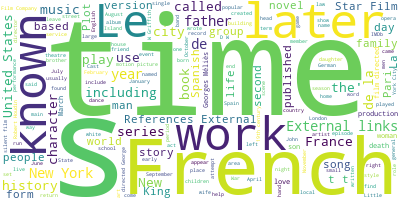

In [32]:
im

## Embeddings

In [33]:
model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}

In [35]:
embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Storing the embeddings in vector database

In [38]:
#!pip install chromadb

In [39]:
db = Chroma.from_documents(splits, embeddings)

In [40]:
persist_directory = '../examData/chroma/'

# Create the vector store
vectordb = Chroma.from_documents(
    documents=splits,
    embedding=embeddings,
    persist_directory=persist_directory
)
vectordb.persist()

In [41]:
vectordb._collection.count()

22179

## Similarity Search

In [42]:
query = 'what is a movie?'

In [43]:
answer = vectordb.similarity_search(query, k=3)
for d in answer:
    print(d.page_content)

A film (British English) – also called a movie (American English), motion picture, moving picture, picture, photoplay or (slang) flick – is a work of visual art that simulates experiences and otherwise communicates ideas, stories, perceptions, feelings, beauty, or atmosphere through the use of moving images. These images are generally accompanied
Movie.
film.


In [44]:
for d in answer:
    print(d.metadata)

{'source': 'https://en.wikipedia.org/wiki/Film', 'summary': 'A film (British English) – also called a movie (American English), motion picture, moving picture, picture, photoplay or (slang) flick – is a work of visual art that simulates experiences and otherwise communicates ideas, stories, perceptions, feelings, beauty, or atmosphere through the use of moving images. These images are generally accompanied by sound and, more rarely, other sensory stimulations. The word "cinema", short for cinematography, is often used to refer to filmmaking and the film industry, and the art form that is the result of it.', 'title': 'Film'}
{'source': 'https://en.wikipedia.org/wiki/Hello_Games', 'summary': "Hello Games Ltd is a British video game company based in Guildford, Surrey. The company was founded by Sean Murray, Grant Duncan, Ryan Doyle and David Ream in February 2008 and has developed the Joe Danger series, No Man's Sky, The Last Campfire, and the upcoming Light No Fire.\n\n", 'title': 'Hello

## Information Retrieval

In [45]:
q1 = 'What is the first ever film?'

In [46]:
q2 = 'What is the worlds best movie?'

In [48]:
q3 = 'Who directed the film Carmencita?'

In [49]:
q4 = 'Which movies has Charlie Chaplin stared in?'

In [50]:
answer = vectordb.max_marginal_relevance_search(q1, k=2, fetch_k=5)
for d in answer:
    print(d.page_content)

1887 – Man Walking Around a Corner, directed by French inventor Louis Le Prince. The oldest known film. Although according to David Wilkinson's 2015 documentary The First Film it's not film, but a series of photographs, 16 in all, each taken from one of the lens from Le Prince's camera. Pictures from the film were sent in a letter dated 18 August
== Critical analysis ==
John Barnes has written that "this could be considered as the first modern film", describing it as "far ahead of its time as regards film technique".


== References ==
Citations


In [51]:
answer = vectordb.max_marginal_relevance_search(q2, k=2, fetch_k=5)
for d in answer:
    print(d.page_content)

Movie.
considered an important film in the history of cinema.


In [52]:
answer = vectordb.max_marginal_relevance_search(q3, k=2, fetch_k=5)
for d in answer:
    print(d.page_content)

the director Segundo de Chomón. Her contribution to his work was not only her participation in the cast, but also in the script and the special effects (in particular, Pathécolor process to which she introduced her husband).
According to film historian Charles Musser, Carmencita was the first woman to appear in a modern motion picture made for commercial purposes and may have been the first woman to appear in a motion picture within the United States. In the film she is recorded going through a routine she had been performing at Koster and Bial's Music Hall in New


In [53]:
answer = vectordb.max_marginal_relevance_search(q4, k=2, fetch_k=5)
for d in answer:
    print(d.page_content)

Arbuckle, Charlie Chaplin, Mary Astor and Pola Negri, but no footage exists.
Arbuckle, Charlie Chaplin, Mary Astor and Pola Negri, but no footage exists.


## Large Language Model

In [54]:
from langchain.llms import Ollama
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

In [61]:
!ollama list

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Error: could not connect to ollama app, is it running?


In [55]:
llm = Ollama(model="mistral", callback_manager = CallbackManager([StreamingStdOutCallbackHandler()]))

In [56]:
# Build prompt
template = """Use the following pieces of context to answer the question at the end. 
If you don't know the answer, just say that you don't know, don't try to make up an answer. 
Use five sentences maximum. Keep the answer as concise as possible. 
Always say "thanks for asking!" at the end of the answer. 

{context}

Question: {question}

Helpful Answer:
"""

In [57]:
prompt = PromptTemplate.from_template(template)
chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt})

In [59]:
question1 = 'What is a movie?'

In [60]:
result1 = chain({"query": question1})
result1["result"]

ConnectionError: HTTPConnectionPool(host='localhost', port=11434): Max retries exceeded with url: /api/generate/ (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x42fcc42c0>: Failed to establish a new connection: [Errno 61] Connection refused'))

In [63]:
import pickle

In [64]:
# Save the model using pickle (optional)
pickle_file = "chatbot_model.pkl"
with open(pickle_file, 'wb') as file:
    pickle.dump(chain, file)

TypeError: cannot pickle '_thread.RLock' object